In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

import acquire_zillow
from acquire_zillow import get_connection
from acquire_zillow import get_properties_2016
from acquire_zillow import get_properties_2017
from acquire_zillow import get_zillow_csv

import prepare_zillow
from prepare_zillow import reindex_zillow
from prepare_zillow import drop_land_listings
from prepare_zillow import convert_num_to_categorical
from prepare_zillow import convert_numerical_object_to_int

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn import linear_model

import scipy.stats as stats
from scipy.stats import pearsonr

from mpl_toolkits.mplot3d import Axes3D

import graphviz
from graphviz import Graph

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

random_state=123

import env

# Running Zach's acquire start

In [514]:
df = pd.read_csv('curr_access.txt', delimiter=' ', header=None)
df.head(4)

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61


In [515]:
df.columns = ['date', 'time', 'path', 'user', 'cohort', 'ip']
df.head(3)

,date,time,path,user,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61


In [516]:
df.user[df.cohort.isnull()].unique()

array([ 48,  54,  58,  59,  61,  62,  63,  73,  74,  78,  79,  86,  88,
        89, 100, 103, 111, 137, 166, 176, 213, 247, 317, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 372, 375])

In [517]:
df.cohort.isnull().sum()

14458

# Later on down the road, we look at data for the Ada cohort.  The original data doesn't contain the Ada name in Cohort.  Because of this, we will manually fill in the names for the users believed to be in the Ada cohort that were previously discovered.

In [518]:
def encode_ada(df):
    students = [349, 351, 352, 353, 354, 355, 357, 359, 361, 362, 363, 364, 366, 367, 368, 369, 372]
    for student in students:
        df.loc[df['user'] == student, 'cohort'] = 30.0
    return df
    

In [519]:
encode_ada(df)
df.user[df.cohort == 30.0].value_counts()

354    1319
368    1136
363    1131
355     638
349     613
366     536
367     499
353     494
364     436
362     412
351     332
361     315
359     285
357     282
352     251
372     206
369     175
Name: user, dtype: int64

In [520]:
df.cohort.isnull().sum()

5398

In [521]:
df.user[df.cohort.isnull()].unique()

array([ 48,  54,  58,  59,  61,  62,  63,  73,  74,  78,  79,  86,  88,
        89, 100, 103, 111, 137, 166, 176, 213, 247, 317, 350, 356, 358,
       360, 365, 375])

In [522]:
list(sorted(df.user[df.cohort == 28].unique()))

[1, 11, 40, 53, 64, 146, 211, 248, 312, 314, 370, 397]

In [523]:
# def encode_instructors(df):
#     instructors = [53, 314, 40, 64, 11, 211, 1, 312, 146, 248, 370, 397]
#     for instructor in instructors:
#         df.loc[df['cohort'] == 1 & df['user'] == instructor, 'cohort'] = 28.0
#     return df

In [524]:
# df[(df['cohort'] == 1) & (df['user'] == 146)]

In [525]:
# inst = encode_instructors(df)
# inst.groupby(inst.cohort)['date'].count()

In [526]:
output = []

with open('cohorts.csv', 'r') as reading:
    file_input = reading.read().split('\n')

for row in file_input:
    output.append(row.split(','))

cohorts = pd.DataFrame(output)
cohorts.head()

,0,1,2,3
0,"""id",name,start_date,"end_date"""
1,"""1",Arches,2014-02-04,"2014-04-22"""
2,"""2",Badlands,2014-06-04,"2014-08-22"""
3,"""3",Carlsbad,2014-09-04,"2014-11-05"""
4,"""4",Denali,2014-10-20,"2015-01-18"""


In [527]:
cohorts[0] = cohorts[0].map(lambda x: x.lstrip('"').rstrip(''))
cohorts.head(3)

,0,1,2,3
0,id,name,start_date,"end_date"""
1,1,Arches,2014-02-04,"2014-04-22"""
2,2,Badlands,2014-06-04,"2014-08-22"""


In [528]:
cohorts[3] = cohorts[3].map(lambda x: x.lstrip('').rstrip('"'))
cohorts.head(3)

,0,1,2,3
0,id,name,start_date,end_date
1,1,Arches,2014-02-04,2014-04-22
2,2,Badlands,2014-06-04,2014-08-22


In [529]:
new_header = cohorts.iloc[0]
cohorts = cohorts[1:]
cohorts.columns = new_header
cohorts.head(3)

,id,name,start_date,end_date
1,1,Arches,2014-02-04,2014-04-22
2,2,Badlands,2014-06-04,2014-08-22
3,3,Carlsbad,2014-09-04,2014-11-05


In [530]:
cohorts.rename(columns={'id': 'cohort_id'}, inplace=True)

In [531]:
df.rename(columns={'cohort': 'cohort_id'}, inplace=True)

In [532]:
df.cohort_id.value_counts()

24.0    34485
22.0    28268
23.0    26655
25.0    24681
26.0    24088
29.0    20471
27.0    19255
30.0     9060
1.0      8821
14.0     6523
21.0     6465
28.0     6163
31.0     2997
13.0     2163
17.0     1805
8.0      1671
18.0     1482
19.0      901
16.0      740
15.0      632
7.0       338
12.0      230
2.0        89
11.0       79
6.0        59
9.0         5
4.0         4
Name: cohort_id, dtype: int64

In [533]:
df.isnull().sum()

date            0
time            0
path            0
user            0
cohort_id    5398
ip              0
dtype: int64

In [534]:
df.cohort_id = df.cohort_id.fillna(0).astype(int)
df.isnull().sum()

date         0
time         0
path         0
user         0
cohort_id    0
ip           0
dtype: int64

In [535]:
df.cohort_id.value_counts()

24    34485
22    28268
23    26655
25    24681
26    24088
29    20471
27    19255
30     9060
1      8821
14     6523
21     6465
28     6163
0      5398
31     2997
13     2163
17     1805
8      1671
18     1482
19      901
16      740
15      632
7       338
12      230
2        89
11       79
6        59
9         5
4         4
Name: cohort_id, dtype: int64

In [536]:
df.dtypes

date         object
time         object
path         object
user          int64
cohort_id     int64
ip           object
dtype: object

In [537]:
cohorts.dtypes

0
cohort_id     object
name          object
start_date    object
end_date      object
dtype: object

In [538]:
cohorts.cohort_id = cohorts.cohort_id.astype(int)
cohorts.dtypes

0
cohort_id      int64
name          object
start_date    object
end_date      object
dtype: object

In [539]:
cohorts.start_date = pd.to_datetime(cohorts.start_date)
cohorts.end_date = pd.to_datetime(cohorts.end_date)

In [540]:
df.tail(3)

,date,time,path,user,cohort_id,ip
233525,2019-04-02,11:11:23,javascript-i,373,31,97.105.19.58
233526,2019-04-02,11:11:25,javascript-i/introduction/working-with-data-ty...,376,31,97.105.19.58
233527,2019-04-02,11:11:29,javascript-i/introduction/working-with-data-ty...,373,31,97.105.19.58


In [541]:
last_date = df.date[-1:]
type(last_date)
# last_date.split(' ')[1]

pandas.core.series.Series

In [542]:
df.dtypes

date         object
time         object
path         object
user          int64
cohort_id     int64
ip           object
dtype: object

In [543]:
df['timestamp'] = df['date'] + ' ' + df['time']

In [544]:
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)
df.date = pd.to_datetime(df.date)
df.time = pd.to_datetime(df.time)
df.dtypes

date         datetime64[ns]
time         datetime64[ns]
path                 object
user                  int64
cohort_id             int64
ip                   object
dtype: object

In [545]:
cohorts['last_data_date'] = pd.to_datetime('2019-04-02')
cohorts

,cohort_id,name,start_date,end_date,last_data_date
1,1,Arches,2014-02-04,2014-04-22,2019-04-02
2,2,Badlands,2014-06-04,2014-08-22,2019-04-02
3,3,Carlsbad,2014-09-04,2014-11-05,2019-04-02
4,4,Denali,2014-10-20,2015-01-18,2019-04-02
5,5,Everglades,2014-11-18,2015-02-24,2019-04-02
6,6,Franklin,2015-02-03,2015-05-26,2019-04-02
7,7,Glacier,2015-06-05,2015-10-06,2019-04-02
8,8,Hampton,2015-09-22,2016-02-06,2019-04-02
9,9,Apollo,2015-03-30,2015-07-29,2019-04-02
10,10,Balboa,2015-11-03,2016-03-11,2019-04-02


In [546]:
cohorts['months_since_start'] = cohorts.last_data_date.dt.to_period('M') - cohorts.start_date.dt.to_period('M')
cohorts['months_since_end'] = cohorts.last_data_date.dt.to_period('M') - cohorts.end_date.dt.to_period('M')
cohorts

,cohort_id,name,start_date,end_date,last_data_date,months_since_start,months_since_end
1,1,Arches,2014-02-04,2014-04-22,2019-04-02,62,60
2,2,Badlands,2014-06-04,2014-08-22,2019-04-02,58,56
3,3,Carlsbad,2014-09-04,2014-11-05,2019-04-02,55,53
4,4,Denali,2014-10-20,2015-01-18,2019-04-02,54,51
5,5,Everglades,2014-11-18,2015-02-24,2019-04-02,53,50
6,6,Franklin,2015-02-03,2015-05-26,2019-04-02,50,47
7,7,Glacier,2015-06-05,2015-10-06,2019-04-02,46,42
8,8,Hampton,2015-09-22,2016-02-06,2019-04-02,43,38
9,9,Apollo,2015-03-30,2015-07-29,2019-04-02,49,45
10,10,Balboa,2015-11-03,2016-03-11,2019-04-02,41,37


In [547]:
df = pd.merge(df, cohorts)
df.head(3)

,date,time,path,user,cohort_id,ip,name,start_date,end_date,last_data_date,months_since_start,months_since_end
0,2018-01-26,2019-05-02 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2019-04-02,43,38
1,2018-01-26,2019-05-02 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2019-04-02,43,38
2,2018-01-26,2019-05-02 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2019-04-02,43,38


In [548]:
df.rename(columns={'name': 'cohort'}, inplace=True)

In [549]:
df.drop(columns={'last_data_date'}, inplace=True)
df.head(3)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,months_since_start,months_since_end
0,2018-01-26,2019-05-02 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38
1,2018-01-26,2019-05-02 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38
2,2018-01-26,2019-05-02 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38


# End Update

In [550]:
df.user.value_counts()

53     5839
64     4768
11     4260
344    2787
1      2639
277    2251
127    2242
304    2053
274    2039
186    2003
272    1954
197    1894
269    1894
263    1868
25     1798
7      1798
275    1791
190    1747
195    1716
5      1701
234    1696
183    1675
302    1670
270    1652
211    1628
215    1617
3      1560
192    1546
2      1541
264    1538
       ... 
92       11
161      11
279      10
77       10
84       10
95        9
141       9
388       8
107       8
104       8
396       7
115       6
214       6
71        5
169       5
152       5
311       5
82        5
246       4
216       4
85        4
81        3
177       3
348       3
97        2
66        1
316       1
165       1
163       1
212       1
Name: user, Length: 371, dtype: int64

Looking below, this seems to support that the cohort column is correctly labeled.  The blank might be the admin.  What about the nan's?  Drop?

In [551]:
df.cohort.value_counts()

Voyageurs    34485
Teddy        28268
Ulysses      26655
Wrangell     24681
Xanadu       24088
Zion         20471
Yosemite     19255
Ada           9060
Arches        8821
Lassen        6523
Sequoia       6465
Staff         6163
Andromeda     2997
Kings         2163
Olympic       1805
Hampton       1671
Pinnacles     1482
Quincy         901
Niagara        740
Mammoth        632
Glacier        338
Joshua         230
Badlands        89
Ike             79
Franklin        59
Apollo           5
Denali           4
Name: cohort, dtype: int64

In [552]:
df.head(15)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,months_since_start,months_since_end
0,2018-01-26,2019-05-02 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38
1,2018-01-26,2019-05-02 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38
2,2018-01-26,2019-05-02 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38
3,2018-01-26,2019-05-02 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38
4,2018-01-26,2019-05-02 10:40:15,javascript-i/functions,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38
5,2018-01-26,2019-05-02 11:26:13,java-i,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38
6,2018-01-26,2019-05-02 11:43:17,mkdocs/search_index.json,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38
7,2018-01-27,2019-05-02 07:49:25,teams/13,1,8,72.177.226.58,Hampton,2015-09-22,2016-02-06,43,38
8,2018-01-29,2019-05-02 11:41:51,javascript-i/conditionals,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38
9,2018-01-29,2019-05-02 11:43:08,javascript-i/loops,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38


In [553]:
df.isnull().sum()

date                  0
time                  0
path                  0
user                  0
cohort_id             0
ip                    0
cohort                0
start_date            0
end_date              0
months_since_start    0
months_since_end      0
dtype: int64

In [554]:
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)
df.dtypes

date                  datetime64[ns]
time                  datetime64[ns]
path                          object
user                           int64
cohort_id                      int64
ip                            object
cohort                        object
start_date            datetime64[ns]
end_date              datetime64[ns]
months_since_start            object
months_since_end              object
dtype: object

In [555]:
df['running_days'] = df['date'] - df['start_date']
df.sample(15)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,months_since_start,months_since_end,running_days
183818,2019-02-01,2019-05-02 14:10:11,mysql/database-design,303,27,97.105.19.58,Yosemite,2018-11-05,2019-04-03,5,0,88 days
179873,2019-01-09,2019-05-02 08:20:45,java-i/strings,308,27,97.105.19.58,Yosemite,2018-11-05,2019-04-03,5,0,65 days
11379,2018-02-28,2019-05-02 09:13:56,java-i,7,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,15,11,51 days
13944,2018-03-09,2019-05-02 08:52:59,java-ii/annotations,29,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,15,11,60 days
30715,2018-01-31,2019-05-02 00:17:58,spring/fundamentals/services,17,21,23.122.42.151,Sequoia,2017-09-27,2018-02-15,19,14,126 days
205229,2019-02-25,2019-05-02 16:26:59,javascript-i/bom-and-dom/dom,323,29,97.105.19.58,Zion,2019-01-22,2019-06-04,3,-2,34 days
214841,2019-03-27,2019-05-02 09:39:08,java-ii,347,29,97.105.19.58,Zion,2019-01-22,2019-06-04,3,-2,64 days
220013,2019-02-26,2019-05-02 16:26:04,03_file_paths,363,30,97.105.19.58,Ada,2019-02-04,2019-06-16,2,-2,22 days
84686,2018-08-29,2019-05-02 11:19:43,html-css/css-ii/bootstrap-grid-system,159,23,67.10.153.249,Ulysses,2018-03-05,2018-07-19,13,9,177 days
127626,2018-08-17,2019-05-02 06:54:47,examples/css/css_selectors.html,218,25,70.94.153.55,Wrangell,2018-07-23,2018-11-29,9,5,25 days


In [556]:
df['days_out'] = df['date'] - df['end_date']
df.sample(15)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,months_since_start,months_since_end,running_days,days_out
127398,2018-08-16,2019-05-02 15:25:12,javascript-i/objects,231,25,97.105.19.58,Wrangell,2018-07-23,2018-11-29,9,5,24 days,-105 days
115781,2018-09-05,2019-05-02 11:42:43,java-ii/interfaces-and-abstract-classes,205,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,11,6,99 days,-36 days
108147,2018-08-13,2019-05-02 10:18:26,mysql/tables,196,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,11,6,76 days,-59 days
189977,2018-12-12,2019-05-02 14:45:26,jquery/ajax/weather-map,64,28,97.105.19.58,Staff,2014-02-04,2014-02-04,62,62,1772 days,1772 days
207108,2019-03-03,2019-05-02 23:13:52,javascript-i/introduction/working-with-data-ty...,341,29,173.174.243.231,Zion,2019-01-22,2019-06-04,3,-2,40 days,-93 days
192509,2019-02-11,2019-05-02 09:40:27,2.00.05_Charts_PivotTables_Sparklines,1,28,97.105.19.58,Staff,2014-02-04,2014-02-04,62,62,1833 days,1833 days
192350,2019-02-06,2019-05-02 10:04:18,java-iii,11,28,97.105.19.58,Staff,2014-02-04,2014-02-04,62,62,1828 days,1828 days
96745,2018-07-03,2019-05-02 14:27:03,/,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,11,6,35 days,-100 days
193208,2019-02-21,2019-05-02 08:12:25,java-iii/deployment-and-dependencies,11,28,97.105.19.58,Staff,2014-02-04,2014-02-04,62,62,1843 days,1843 days
124471,2018-08-03,2019-05-02 19:31:26,html-css/css-ii/bootstrap-grid-system,228,25,173.239.232.47,Wrangell,2018-07-23,2018-11-29,9,5,11 days,-118 days


In [557]:
df['running_days'] = (df['running_days']/np.timedelta64(1, 'D')).astype(int)
df['days_out'] = (df['days_out']/np.timedelta64(1, 'D')).astype(int)
df.head(3)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,months_since_start,months_since_end,running_days,days_out
0,2018-01-26,2019-05-02 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38,857,720
1,2018-01-26,2019-05-02 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38,857,720
2,2018-01-26,2019-05-02 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38,857,720


In [558]:
df.groupby(df.cohort)['date'].count()

cohort
Ada           9060
Andromeda     2997
Apollo           5
Arches        8821
Badlands        89
Denali           4
Franklin        59
Glacier        338
Hampton       1671
Ike             79
Joshua         230
Kings         2163
Lassen        6523
Mammoth        632
Niagara        740
Olympic       1805
Pinnacles     1482
Quincy         901
Sequoia       6465
Staff         6163
Teddy        28268
Ulysses      26655
Voyageurs    34485
Wrangell     24681
Xanadu       24088
Yosemite     19255
Zion         20471
Name: date, dtype: int64

In [559]:
out_of_school = df[df.days_out>0]
out_of_school.head(3)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,months_since_start,months_since_end,running_days,days_out
0,2018-01-26,2019-05-02 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38,857,720
1,2018-01-26,2019-05-02 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38,857,720
2,2018-01-26,2019-05-02 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,43,38,857,720


In [560]:
out_of_school.sample(10)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,months_since_start,months_since_end,running_days,days_out
120623,2019-01-15,2019-05-02 15:18:37,search/search_index.json,189,24,170.248.173.246,Voyageurs,2018-05-29,2018-10-11,11,6,231,96
27622,2018-06-07,2019-05-02 14:29:46,java-iii/servlets,99,22,67.11.154.74,Teddy,2018-01-08,2018-05-17,15,11,150,21
189858,2018-12-11,2019-05-02 15:09:55,java-iii/user-input,53,28,97.105.19.58,Staff,2014-02-04,2014-02-04,62,62,1771,1771
35267,2018-07-11,2019-05-02 14:42:51,/,16,21,148.66.37.91,Sequoia,2017-09-27,2018-02-15,19,14,287,146
53935,2018-06-22,2019-05-02 15:23:59,jquery/introduction,53,14,97.105.19.61,Lassen,2016-07-18,2016-11-10,33,29,704,589
119835,2018-11-03,2019-05-02 11:08:44,spring/fundamentals/services,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11,11,6,158,23
36983,2018-03-07,2019-05-02 09:57:08,html-css/css-i,60,1,97.105.19.61,Arches,2014-02-04,2014-04-22,62,60,1492,1415
84722,2018-08-31,2019-05-02 10:06:36,content/git,159,23,67.10.153.249,Ulysses,2018-03-05,2018-07-19,13,9,179,43
145750,2019-02-13,2019-05-02 19:36:33,/,282,25,70.122.250.222,Wrangell,2018-07-23,2018-11-29,9,5,205,76
41724,2018-08-13,2019-05-02 09:55:19,mysql/clauses/where,64,1,97.105.19.58,Arches,2014-02-04,2014-04-22,62,60,1651,1574


In [561]:
out_of_school.groupby(out_of_school.cohort)['date'].count()

cohort
Apollo          5
Arches       8821
Badlands       89
Denali          4
Franklin       59
Glacier       338
Hampton      1671
Ike            79
Joshua        230
Kings        2163
Lassen       6523
Mammoth       632
Niagara       740
Olympic      1805
Pinnacles    1482
Quincy        901
Sequoia      4273
Staff        6163
Teddy        2982
Ulysses      2561
Voyageurs    2130
Wrangell      618
Xanadu       1574
Name: date, dtype: int64

In [562]:
df.shape

(228130, 13)

In [563]:
sum(out_of_school.groupby(out_of_school.cohort)['date'].count())

45843

In [564]:
sum(during_school.groupby(during_school.cohort)['date'].count())

181183

In [565]:
df.groupby(df.cohort)['user'].nunique()

cohort
Ada          17
Andromeda    23
Apollo        1
Arches       17
Badlands      3
Denali        1
Franklin      1
Glacier       5
Hampton       4
Ike           4
Joshua        4
Kings        10
Lassen       10
Mammoth       4
Niagara       8
Olympic      10
Pinnacles    13
Quincy       13
Sequoia      27
Staff        12
Teddy        34
Ulysses      33
Voyageurs    33
Wrangell     26
Xanadu       20
Yosemite     27
Zion         25
Name: user, dtype: int64

## Below is the amount of visits per student after leaving Codeup.

In [566]:
out_of_school_vps = pd.DataFrame(out_of_school.groupby(out_of_school.cohort)['date'].count()/df.groupby(df.cohort)['user'].nunique())
out_of_school_vps.reset_index(inplace=True)
out_of_school_vps.rename(columns={'cohort':'name', 0:'avg_vis_stud'}, inplace=True)
out_of_school_vps

,name,avg_vis_stud
0,Ada,NaN
1,Andromeda,NaN
2,Apollo,5.000000
3,Arches,518.882353
4,Badlands,29.666667
5,Denali,4.000000
6,Franklin,59.000000
7,Glacier,67.600000
8,Hampton,417.750000
9,Ike,19.750000


# These are average amount of searches per cohort per month, roughly.

In [567]:
cohorts.head(3)

,cohort_id,name,start_date,end_date,last_data_date,months_since_start,months_since_end
1,1,Arches,2014-02-04,2014-04-22,2019-04-02,62,60
2,2,Badlands,2014-06-04,2014-08-22,2019-04-02,58,56
3,3,Carlsbad,2014-09-04,2014-11-05,2019-04-02,55,53


In [568]:
months = cohorts[['name','months_since_start', 'months_since_end']]
months.head(3)

,name,months_since_start,months_since_end
1,Arches,62,60
2,Badlands,58,56
3,Carlsbad,55,53


In [569]:
months['months_since_start'] = months['months_since_start'].astype(str).astype(int)
months['months_since_end'] = months['months_since_end'].astype(str).astype(int)

In [570]:
months.dtypes

0
name                  object
months_since_start     int64
months_since_end       int64
dtype: object

In [571]:
out_of_school_vps.head(3)

,name,avg_vis_stud
0,Ada,NaN
1,Andromeda,NaN
2,Apollo,5.0


In [494]:
out_of_school_vps.dtypes

name    float64
dtype: object

In [572]:
out_of_school_vps = pd.merge(out_of_school_vps, months, how='left', on='name')
out_of_school_vps

,name,avg_vis_stud,months_since_start,months_since_end
0,Ada,NaN,2,-2
1,Andromeda,NaN,1,-3
2,Apollo,5.000000,49,45
3,Arches,518.882353,62,60
4,Badlands,29.666667,58,56
5,Denali,4.000000,54,51
6,Franklin,59.000000,50,47
7,Glacier,67.600000,46,42
8,Hampton,417.750000,43,38
9,Ike,19.750000,39,35


In [573]:
out_of_school_vps['avg_vis_per_pers_per_month'] = out_of_school_vps.avg_vis_stud/out_of_school_vps.months_since_end

In [574]:
out_of_school_vps

,name,avg_vis_stud,months_since_start,months_since_end,avg_vis_per_pers_per_month
0,Ada,NaN,2,-2,NaN
1,Andromeda,NaN,1,-3,NaN
2,Apollo,5.000000,49,45,0.111111
3,Arches,518.882353,62,60,8.648039
4,Badlands,29.666667,58,56,0.529762
5,Denali,4.000000,54,51,0.078431
6,Franklin,59.000000,50,47,1.255319
7,Glacier,67.600000,46,42,1.609524
8,Hampton,417.750000,43,38,10.993421
9,Ike,19.750000,39,35,0.564286


In [575]:
during_school = df[df.days_out <= 0]
during_school = during_school[during_school.start_date < during_school.date]
during_school.head()

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,months_since_start,months_since_end,running_days,days_out
1671,2018-01-26,2019-05-02 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,15,11,18,-111
1672,2018-01-26,2019-05-02 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,15,11,18,-111
1673,2018-01-26,2019-05-02 09:56:46,javascript-i/conditionals,3,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,15,11,18,-111
1674,2018-01-26,2019-05-02 09:56:48,javascript-i/functions,3,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,15,11,18,-111
1675,2018-01-26,2019-05-02 09:56:59,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,15,11,18,-111


In [261]:
during_school.date[during_school.cohort_id == 30].count()

9040

In [229]:
during_school.groupby(during_school.cohort)['date'].count()

cohort
Ada           9040
Andromeda     2974
Sequoia       2192
Teddy        25286
Ulysses      23901
Voyageurs    32251
Wrangell     23802
Xanadu       22417
Yosemite     19098
Zion         20222
Name: date, dtype: int64

In [262]:
9040/17

531.7647058823529

In [230]:
during_school_vps = pd.DataFrame(during_school.groupby(during_school.cohort)['date'].count()/df.groupby(df.cohort)['user'].nunique())
during_school_vps

,0
cohort,
Ada,531.764706
Andromeda,129.304348
Apollo,NaN
Arches,NaN
Badlands,NaN
Denali,NaN
Franklin,NaN
Glacier,NaN
Hampton,NaN


In [268]:
df.date[-1] - df.end

Timestamp('2019-04-02 00:00:00')

In [267]:
during_school_vps/2

,0
cohort,
Ada,265.882353
Andromeda,64.652174
Apollo,NaN
Arches,NaN
Badlands,NaN
Denali,NaN
Franklin,NaN
Glacier,NaN
Hampton,NaN


In [231]:
during_school_vps/30

,0
cohort,
Ada,17.725490
Andromeda,4.310145
Apollo,NaN
Arches,NaN
Badlands,NaN
Denali,NaN
Franklin,NaN
Glacier,NaN
Hampton,NaN


## Below are students that were in more than one cohort.

In [211]:
df[df.user == 88]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out
timestamp,,,,,,,,,,,
2018-06-01 15:14:04,2018-06-01,2019-05-02 15:14:04,/,88,7,66.90.136.214,Glacier,2015-06-05,2015-10-06,1092,969
2018-06-01 15:14:19,2018-06-01,2019-05-02 15:14:19,javascript-ii,88,7,66.90.136.214,Glacier,2015-06-05,2015-10-06,1092,969
2018-06-01 15:15:07,2018-06-01,2019-05-02 15:15:07,javascript-ii,88,7,66.90.136.214,Glacier,2015-06-05,2015-10-06,1092,969
2018-06-01 15:15:13,2018-06-01,2019-05-02 15:15:13,javascript-ii,88,7,66.90.136.214,Glacier,2015-06-05,2015-10-06,1092,969
2018-06-01 15:15:17,2018-06-01,2019-05-02 15:15:17,php,88,7,66.90.136.214,Glacier,2015-06-05,2015-10-06,1092,969
2018-06-01 15:16:31,2018-06-01,2019-05-02 15:16:31,/,88,7,66.90.136.214,Glacier,2015-06-05,2015-10-06,1092,969
2018-06-01 15:16:54,2018-06-01,2019-05-02 15:16:54,content/php_i,88,7,66.90.136.214,Glacier,2015-06-05,2015-10-06,1092,969
2018-06-01 15:16:54,2018-06-01,2019-05-02 15:16:54,content/php_i/gitbook/images/favicon.ico,88,7,66.90.136.214,Glacier,2015-06-05,2015-10-06,1092,969
2018-06-01 15:16:57,2018-06-01,2019-05-02 15:16:57,content/php_i/intro-via-interactive-shell,88,7,66.90.136.214,Glacier,2015-06-05,2015-10-06,1092,969


In [212]:
s_only = df[df.cohort_id != 28]
g = pd.DataFrame(s_only.groupby(s_only.user).cohort_id.nunique())
g[g.cohort_id > 1]

,cohort_id
user,
25,2
88,3
118,2


In [213]:
df[df.user == 25]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out
timestamp,,,,,,,,,,,
2018-01-26 11:36:00,2018-01-26,2019-05-02 11:36:00,mkdocs/search_index.json,25,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,18,-111
2018-01-26 11:41:09,2018-01-26,2019-05-02 11:41:09,javascript-i/functions,25,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,18,-111
2018-01-26 11:44:57,2018-01-26,2019-05-02 11:44:57,javascript-i/functions,25,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,18,-111
2018-01-26 12:03:33,2018-01-26,2019-05-02 12:03:33,javascript-i/functions,25,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,18,-111
2018-01-26 14:32:34,2018-01-26,2019-05-02 14:32:34,/,25,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,18,-111
2018-01-29 09:02:25,2018-01-29,2019-05-02 09:02:25,/,25,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,21,-108
2018-01-29 09:02:30,2018-01-29,2019-05-02 09:02:30,javascript-i,25,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,21,-108
2018-01-29 09:02:34,2018-01-29,2019-05-02 09:02:34,javascript-i/conditionals,25,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,21,-108
2018-01-29 09:35:59,2018-01-29,2019-05-02 09:35:59,javascript-i,25,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,21,-108


In [214]:
df[df.user == 118]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out
timestamp,,,,,,,,,,,
2018-06-11 08:40:05,2018-06-11,2019-05-02 08:40:05,/,118,13,137.242.1.129,Kings,2016-05-23,2016-09-15,749,634
2018-06-11 08:40:07,2018-06-11,2019-05-02 08:40:07,/,118,13,137.242.1.129,Kings,2016-05-23,2016-09-15,749,634
2018-06-11 08:40:33,2018-06-11,2019-05-02 08:40:33,html-css,118,13,137.242.1.129,Kings,2016-05-23,2016-09-15,749,634
2018-06-11 08:40:43,2018-06-11,2019-05-02 08:40:43,java-i,118,13,137.242.1.129,Kings,2016-05-23,2016-09-15,749,634
2018-06-11 08:40:49,2018-06-11,2019-05-02 08:40:49,java-i/introduction-to-java,118,13,137.242.1.129,Kings,2016-05-23,2016-09-15,749,634
2018-06-11 08:41:20,2018-06-11,2019-05-02 08:41:20,java-i/syntax-types-and-variables,118,13,137.242.1.129,Kings,2016-05-23,2016-09-15,749,634
2018-06-11 08:41:24,2018-06-11,2019-05-02 08:41:24,java-i/console-io,118,13,137.242.1.129,Kings,2016-05-23,2016-09-15,749,634
2018-07-09 07:32:53,2018-07-09,2019-05-02 07:32:53,/,118,13,137.242.1.128,Kings,2016-05-23,2016-09-15,777,662
2018-07-09 07:32:58,2018-07-09,2019-05-02 07:32:58,/,118,13,137.242.1.128,Kings,2016-05-23,2016-09-15,777,662


## To start looking for some anomalies, we'll focus one a single cohort.

In [32]:
cohort_24 = df[df.cohort_id == 24]
cohort_24.head()

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-05-29 14:42:38,2018-05-29,2019-05-02 14:42:38,/,182,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-29 14:42:39,2018-05-29,2019-05-02 14:42:39,/,183,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,184,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,185,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11


In [33]:
cohort_24.tail()

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2019-03-29 17:28:34,2019-03-29,2019-05-02 17:28:34,spring,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11
2019-03-29 17:28:37,2019-03-29,2019-05-02 17:28:37,spring/setup,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11
2019-03-29 17:34:38,2019-03-29,2019-05-02 17:34:38,spring/fundamentals/controllers,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11
2019-03-29 17:42:08,2019-03-29,2019-05-02 17:42:08,spring/fundamentals/controllers,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11
2019-03-29 17:42:19,2019-03-29,2019-05-02 17:42:19,spring/fundamentals/views,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11


In [34]:
cohort_24['date'].value_counts()

2018-08-17    917
2018-08-13    734
2018-08-27    726
2018-08-06    686
2018-06-12    677
2018-08-14    669
2018-07-23    659
2018-06-01    579
2018-06-21    577
2018-08-09    561
2018-06-11    559
2018-06-04    554
2018-07-24    554
2018-08-23    539
2018-07-09    536
2018-06-29    516
2018-06-26    504
2018-08-10    503
2018-09-05    498
2018-08-07    479
2018-08-15    462
2018-08-01    459
2018-07-31    453
2018-07-11    438
2018-08-02    436
2018-07-03    436
2018-07-12    436
2018-06-28    408
2018-07-25    408
2018-08-20    406
             ... 
2019-02-14      4
2019-01-31      4
2018-11-26      4
2018-10-27      4
2018-11-15      4
2018-11-28      4
2018-12-28      4
2019-02-02      3
2018-10-03      3
2019-03-18      3
2019-02-20      3
2019-02-16      3
2019-02-04      3
2018-12-06      3
2018-11-29      3
2018-12-30      2
2018-11-27      2
2019-03-13      2
2019-02-07      1
2019-02-21      1
2019-03-05      1
2019-02-08      1
2019-02-22      1
2018-12-14      1
2019-02-06

In [35]:
cohort_24['running_days'] = cohort_24['date'] - (cohort_24['start_date'])
cohort_24.sample(15)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days
timestamp,,,,,,,,,,
2018-08-03 10:56:46,2018-08-03,2019-05-02 10:56:46,java-ii/arrays,192,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,66 days
2018-07-13 08:14:19,2018-07-13,2019-05-02 08:14:19,java-i/control-statements-and-loops,187,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,45 days
2018-05-31 14:42:27,2018-05-31,2019-05-02 14:42:27,html-css/forms,195,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,2 days
2018-07-12 14:22:03,2018-07-12,2019-05-02 14:22:03,javascript-ii/map-filter-reduce,193,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,44 days
2018-07-03 15:39:36,2018-07-03,2019-05-02 15:39:36,jquery/simple-simon,187,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,35 days
2018-06-05 08:29:48,2018-06-05,2019-05-02 08:29:48,html-css/css-ii/media-queries,183,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,7 days
2018-08-02 14:53:30,2018-08-02,2019-05-02 14:53:30,java-ii/collections,207,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,65 days
2018-07-02 13:38:30,2018-07-02,2019-05-02 13:38:30,/,208,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,34 days
2018-09-06 10:00:03,2018-09-06,2019-05-02 10:00:03,spring/fundamentals/views,189,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,100 days


In [36]:
cohort_24['days_out'] = cohort_24['date'] - (cohort_24['end_date'])
cohort_24.sample(15)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out
timestamp,,,,,,,,,,,
2018-08-22 21:34:24,2018-08-22,2019-05-02 21:34:24,java-iii/finish-the-adlister,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11,85 days,-50 days
2018-08-15 11:09:48,2018-08-15,2019-05-02 11:09:48,mysql/relationships/joins,206,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,78 days,-57 days
2018-08-17 09:07:46,2018-08-17,2019-05-02 09:07:46,mysql/introduction,182,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,80 days,-55 days
2018-06-07 15:22:36,2018-06-07,2019-05-02 15:22:36,html-css/css-ii/grids,200,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,9 days,-126 days
2018-08-13 15:04:06,2018-08-13,2019-05-02 15:04:06,mysql/clauses/order-by,195,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,76 days,-59 days
2018-09-12 09:20:58,2018-09-12,2019-05-02 09:20:58,mysql/intellij,251,24,192.171.117.210,Voyageurs,2018-05-29,2018-10-11,106 days,-29 days
2018-07-23 08:15:44,2018-07-23,2019-05-02 08:15:44,javascript-ii/promises,204,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,55 days,-80 days
2018-09-12 21:16:18,2018-09-12,2019-05-02 21:16:18,spring/fundamentals/views,196,24,67.11.175.66,Voyageurs,2018-05-29,2018-10-11,106 days,-29 days
2018-06-29 09:55:57,2018-06-29,2019-05-02 09:55:57,jquery,194,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,31 days,-104 days


In [37]:
cohort_24.dtypes

date             datetime64[ns]
time             datetime64[ns]
path                     object
user                      int64
cohort_id                 int64
ip                       object
cohort                   object
start_date       datetime64[ns]
end_date         datetime64[ns]
running_days    timedelta64[ns]
days_out        timedelta64[ns]
dtype: object

In [38]:
cohort_24['running_days'] = (cohort_24['running_days']/np.timedelta64(1, 'D')).astype(int)
cohort_24['days_out'] = (cohort_24['days_out']/np.timedelta64(1, 'D')).astype(int)

In [39]:
cohort_24.head()

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out
timestamp,,,,,,,,,,,
2018-05-29 14:42:38,2018-05-29,2019-05-02 14:42:38,/,182,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135
2018-05-29 14:42:39,2018-05-29,2019-05-02 14:42:39,/,183,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,184,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,185,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135


In [40]:
cohort_24.dtypes

date            datetime64[ns]
time            datetime64[ns]
path                    object
user                     int64
cohort_id                int64
ip                      object
cohort                  object
start_date      datetime64[ns]
end_date        datetime64[ns]
running_days             int64
days_out                 int64
dtype: object

In [41]:
cohort_24.user.unique()

array([182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 215, 249, 250, 251, 253, 278])

In [42]:
cohort_24 = cohort_24[cohort_24.user < 214]

In [43]:
cohort_24[cohort_24.running_days > 200]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out
timestamp,,,,,,,,,,,
2018-12-16 15:47:35,2018-12-16,2019-05-02 15:47:35,/,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11,201,66
2018-12-16 15:47:39,2018-12-16,2019-05-02 15:47:39,spring,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11,201,66
2018-12-16 15:47:42,2018-12-16,2019-05-02 15:47:42,spring/setup,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11,201,66
2018-12-16 15:52:45,2018-12-16,2019-05-02 15:52:45,spring/fundamentals/controllers,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11,201,66
2018-12-16 15:52:50,2018-12-16,2019-05-02 15:52:50,spring/fundamentals/views,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11,201,66
2018-12-16 16:15:03,2018-12-16,2019-05-02 16:15:03,spring/setup,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11,201,66
2018-12-17 14:42:10,2018-12-17,2019-05-02 14:42:10,java-i/control-statements-and-loops,187,24,4.16.216.161,Voyageurs,2018-05-29,2018-10-11,202,67
2018-12-17 14:42:27,2018-12-17,2019-05-02 14:42:27,java-i/strings,187,24,4.16.216.161,Voyageurs,2018-05-29,2018-10-11,202,67
2018-12-17 14:42:47,2018-12-17,2019-05-02 14:42:47,java-i/methods,187,24,4.16.216.161,Voyageurs,2018-05-29,2018-10-11,202,67


In [44]:
cohort_24.groupby(cohort_24.date).count()

,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out
date,,,,,,,,,,
2018-05-29,104,104,104,104,104,104,104,104,104,104
2018-05-30,324,324,324,324,324,324,324,324,324,324
2018-05-31,355,355,355,355,355,355,355,355,355,355
2018-06-01,579,579,579,579,579,579,579,579,579,579
2018-06-02,53,53,53,53,53,53,53,53,53,53
2018-06-03,83,83,83,83,83,83,83,83,83,83
2018-06-04,554,554,554,554,554,554,554,554,554,554
2018-06-05,230,230,230,230,230,230,230,230,230,230
2018-06-06,251,251,251,251,251,251,251,251,251,251


In [45]:
cohort_24['day_of_week'] = cohort_24['date'].dt.day_name()
cohort_24.sample(10)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out,day_of_week
timestamp,,,,,,,,,,,,
2018-11-04 14:23:35,2018-11-04,2019-05-02 14:23:35,appendix,186,24,99.158.248.205,Voyageurs,2018-05-29,2018-10-11,159,24,Sunday
2018-08-07 09:12:22,2018-08-07,2019-05-02 09:12:22,java-ii/annotations,192,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,70,-65,Tuesday
2018-08-03 10:52:03,2018-08-03,2019-05-02 10:52:03,slides/collections,207,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,66,-69,Friday
2018-06-26 10:55:28,2018-06-26,2019-05-02 10:55:28,javascript-i,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,28,-107,Tuesday
2018-07-10 11:00:29,2018-07-10,2019-05-02 11:00:29,jquery/ajax/weather-map,184,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,42,-93,Tuesday
2018-08-17 09:09:39,2018-08-17,2019-05-02 09:09:39,java-iii,189,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,80,-55,Friday
2018-08-12 16:05:42,2018-08-12,2019-05-02 16:05:42,mysql/intellij,197,24,66.69.49.204,Voyageurs,2018-05-29,2018-10-11,75,-60,Sunday
2018-08-31 13:50:43,2018-08-31,2019-05-02 13:50:43,mysql/relationships/joins,185,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,94,-41,Friday
2018-06-13 14:41:30,2018-06-13,2019-05-02 14:41:30,javascript-i/introduction/primitive-types,197,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,15,-120,Wednesday


In [46]:
cohort_24.groupby(cohort_24.day_of_week)['date'].count()

day_of_week
Friday       5124
Monday       7208
Saturday      811
Sunday       1237
Thursday     5787
Tuesday      6474
Wednesday    5447
Name: date, dtype: int64

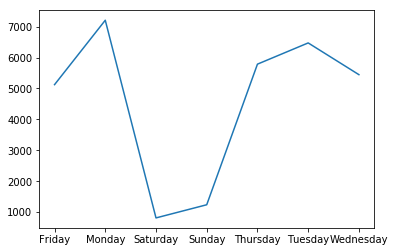

In [47]:
plt.plot(cohort_24.groupby(cohort_24.day_of_week)['date'].count())

In [48]:
cohort_24_over_130 = cohort_24[cohort_24.days_out > 0]
cohort_24_over_130.shape

(1693, 12)

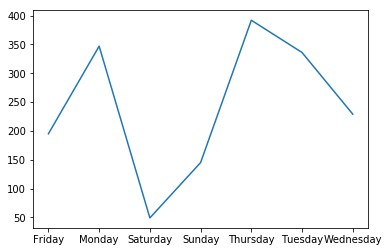

In [49]:
plt.plot(cohort_24_over_130.groupby(cohort_24_over_130.day_of_week)['date'].count())

In [50]:
cohort_24.groupby(cohort_24.user)['date'].count()

user
182     856
183    1675
184    1023
185    1111
186    2003
187    1297
188    1482
189    1511
190    1747
191    1239
192    1546
193    1026
194     927
195    1716
196    1153
197    1894
198     705
199    1408
200     760
201     762
202     365
203    1083
204    1351
205     886
206     469
207     969
208    1124
Name: date, dtype: int64

In [51]:
cohort_24_under_130 = cohort_24[cohort_24.days_out <= 0]
cohort_24_under_130.shape

(30395, 12)

In [52]:
cohort_24_under_130.sample(10)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out,day_of_week
timestamp,,,,,,,,,,,,
2018-06-21 22:31:18,2018-06-21,2019-05-02 22:31:18,javascript-i/introduction/primitive-types,198,24,99.132.129.169,Voyageurs,2018-05-29,2018-10-11,23,-112,Thursday
2018-07-11 17:02:17,2018-07-11,2019-05-02 17:02:17,jquery/essential-methods/attributes-and-css,207,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,43,-92,Wednesday
2018-06-26 12:21:12,2018-06-26,2019-05-02 12:21:12,mkdocs/search_index.json,202,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,28,-107,Tuesday
2018-09-05 08:55:50,2018-09-05,2019-05-02 08:55:50,mysql,189,24,97.105.19.58,Voyageurs,2018-05-29,2018-10-11,99,-36,Wednesday
2018-06-14 12:36:43,2018-06-14,2019-05-02 12:36:43,javascript-i/introduction/working-with-data-ty...,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,16,-119,Thursday
2018-06-20 14:23:12,2018-06-20,2019-05-02 14:23:12,javascript-i/arrays/manipulating,194,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,22,-113,Wednesday
2018-06-06 10:42:43,2018-06-06,2019-05-02 10:42:43,html-css/css-ii/media-queries,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,8,-127,Wednesday
2018-06-12 09:02:10,2018-06-12,2019-05-02 09:02:10,javascript-i/introduction/working-with-data-ty...,194,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,14,-121,Tuesday
2018-07-13 11:03:35,2018-07-13,2019-05-02 11:03:35,javascript-ii,192,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,45,-90,Friday


In [53]:
cohort_24_under_130.groupby(cohort_24_under_130.user)['date'].count()

user
182     856
183    1621
184    1009
185    1046
186    1468
187    1204
188    1322
189    1203
190    1730
191    1239
192    1546
193    1003
194     927
195    1598
196    1153
197    1785
198     624
199    1408
200     756
201     687
202     365
203    1083
204    1321
205     886
206     463
207     969
208    1123
Name: date, dtype: int64

In [54]:
cohort_24_over_130.groupby(cohort_24_over_130.user)['date'].count()

user
183     54
184     14
185     65
186    535
187     93
188    160
189    308
190     17
193     23
195    118
197    109
198     81
200      4
201     75
204     30
206      6
208      1
Name: date, dtype: int64

In [55]:
cohort_24_user_grouped = pd.DataFrame(cohort_24_under_130.user.value_counts()).reset_index().\
    rename(index=str, columns={'index':'user', 'user':'count'})
cohort_24_user_grouped

,user,count
0,197,1785
1,190,1730
2,183,1621
3,195,1598
4,192,1546
5,186,1468
6,199,1408
7,188,1322
8,204,1321
9,191,1239


In [56]:
cohort_24_under_130.dtypes

date            datetime64[ns]
time            datetime64[ns]
path                    object
user                     int64
cohort_id                int64
ip                      object
cohort                  object
start_date      datetime64[ns]
end_date        datetime64[ns]
running_days             int64
days_out                 int64
day_of_week             object
dtype: object

In [57]:
cohort_24_under_130.dropna(inplace=True)

In [58]:
cohort_24_under_130.user.count()

30395

In [59]:
cohort_24_grouped_proba = pd.DataFrame(cohort_24_under_130.user.value_counts()/cohort_24_under_130.user.count()).reset_index().rename(index=str, columns={'index':'user', 'user':'proba_during'})
cohort_24_grouped_proba

,user,proba_during
0,197,0.058727
1,190,0.056917
2,183,0.053331
3,195,0.052574
4,192,0.050864
5,186,0.048297
6,199,0.046323
7,188,0.043494
8,204,0.043461
9,191,0.040763


In [60]:
cohort_24_grouped_proba_after = pd.DataFrame(cohort_24_over_130.user.value_counts()/cohort_24_over_130.user.count()).reset_index().rename(index=str, columns={'index':'user', 'user':'proba_after'})
cohort_24_grouped_proba_after

,user,proba_after
0,186,0.316007
1,189,0.181926
2,188,0.094507
3,195,0.069699
4,197,0.064383
5,187,0.054932
6,198,0.047844
7,201,0.044300
8,185,0.038393
9,183,0.031896


In [61]:
cohort_24_over_130.user.value_counts()

186    535
189    308
188    160
195    118
197    109
187     93
198     81
201     75
185     65
183     54
204     30
193     23
190     17
184     14
206      6
200      4
208      1
Name: user, dtype: int64

In [62]:
cohort_24_under_130.user.value_counts()

197    1785
190    1730
183    1621
195    1598
192    1546
186    1468
199    1408
188    1322
204    1321
191    1239
187    1204
189    1203
196    1153
208    1123
203    1083
185    1046
184    1009
193    1003
207     969
194     927
205     886
182     856
200     756
201     687
198     624
206     463
202     365
Name: user, dtype: int64

In [63]:
cohort_24_grouped_proba_after_overall = pd.DataFrame(cohort_24_over_130.user.value_counts()/(cohort_24_over_130.user.value_counts()+cohort_24_under_130.user.value_counts())).reset_index().rename(index=str, columns={'index':'user', 'user':'percent_after'})
cohort_24_grouped_proba_after_overall 

,user,percent_after
0,182,NaN
1,183,0.032239
2,184,0.013685
3,185,0.058506
4,186,0.267099
5,187,0.071704
6,188,0.107962
7,189,0.203839
8,190,0.009731
9,191,NaN


In [64]:
cohort_24_proba = cohort_24_grouped_proba.merge(cohort_24_grouped_proba_after, 'left', on='user')
cohort_24_proba

,user,proba_during,proba_after
0,197,0.058727,0.064383
1,190,0.056917,0.010041
2,183,0.053331,0.031896
3,195,0.052574,0.069699
4,192,0.050864,NaN
5,186,0.048297,0.316007
6,199,0.046323,NaN
7,188,0.043494,0.094507
8,204,0.043461,0.017720
9,191,0.040763,NaN


In [65]:
cohort_24_proba = cohort_24_proba.merge(cohort_24_grouped_proba_after_overall, 'left', on='user')
cohort_24_proba

,user,proba_during,proba_after,percent_after
0,197,0.058727,0.064383,0.057550
1,190,0.056917,0.010041,0.009731
2,183,0.053331,0.031896,0.032239
3,195,0.052574,0.069699,0.068765
4,192,0.050864,NaN,NaN
5,186,0.048297,0.316007,0.267099
6,199,0.046323,NaN,NaN
7,188,0.043494,0.094507,0.107962
8,204,0.043461,0.017720,0.022206
9,191,0.040763,NaN,NaN


In [66]:
cohort_24_proba.fillna(0)

,user,proba_during,proba_after,percent_after
0,197,0.058727,0.064383,0.057550
1,190,0.056917,0.010041,0.009731
2,183,0.053331,0.031896,0.032239
3,195,0.052574,0.069699,0.068765
4,192,0.050864,0.000000,0.000000
5,186,0.048297,0.316007,0.267099
6,199,0.046323,0.000000,0.000000
7,188,0.043494,0.094507,0.107962
8,204,0.043461,0.017720,0.022206
9,191,0.040763,0.000000,0.000000


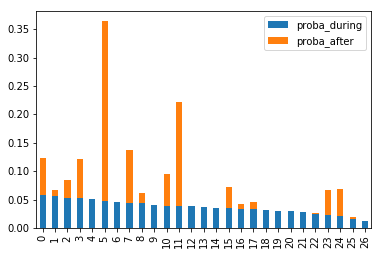

In [67]:
cohort_24_proba[['proba_during', 'proba_after']].plot(kind='bar', stacked=True)


In [68]:
df[df.user == 186]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-29 14:43:22,2018-05-29,2019-05-02 14:43:22,html-css,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 10:50:46,2018-05-30,2019-05-02 10:50:46,appendix,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 10:50:52,2018-05-30,2019-05-02 10:50:52,appendix/git/intellij-intro,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 11:47:27,2018-05-30,2019-05-02 11:47:27,html-css,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 11:48:28,2018-05-30,2019-05-02 11:48:28,appendix,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 11:48:32,2018-05-30,2019-05-02 11:48:32,appendix/git/intellij,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 12:58:59,2018-05-30,2019-05-02 12:58:59,appendix/git/cli,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 13:35:37,2018-05-30,2019-05-02 13:35:37,html-css,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11


In [69]:
df[df.user == 189]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-05-29 14:42:45,2018-05-29,2019-05-02 14:42:45,/,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 09:06:42,2018-05-30,2019-05-02 09:06:42,html-css,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 09:06:48,2018-05-30,2019-05-02 09:06:48,html-css/introduction,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 09:06:55,2018-05-30,2019-05-02 09:06:55,html-css,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 09:07:36,2018-05-30,2019-05-02 09:07:36,html-css/introduction,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 10:50:46,2018-05-30,2019-05-02 10:50:46,appendix,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 10:50:50,2018-05-30,2019-05-02 10:50:50,appendix/git/intellij-intro,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 13:35:26,2018-05-30,2019-05-02 13:35:26,html-css,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 13:37:46,2018-05-30,2019-05-02 13:37:46,html-css/introduction,189,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11


In [70]:
df[df.user == 188]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-05-29 14:42:44,2018-05-29,2019-05-02 14:42:44,/,188,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 10:50:58,2018-05-30,2019-05-02 10:50:58,/,188,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 10:51:11,2018-05-30,2019-05-02 10:51:11,html-css/introduction,188,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 11:46:10,2018-05-30,2019-05-02 11:46:10,appendix/git/intellij-intro,188,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 11:47:06,2018-05-30,2019-05-02 11:47:06,appendix/git/intellij,188,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 13:38:15,2018-05-30,2019-05-02 13:38:15,/,188,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 13:38:21,2018-05-30,2019-05-02 13:38:21,html-css/introduction,188,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 13:44:11,2018-05-30,2019-05-02 13:44:11,appendix/git/intellij,188,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11
2018-05-30 15:16:35,2018-05-30,2019-05-02 15:16:35,html-css/elements,188,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11


In [71]:
cohort_24[cohort_24.ip == '170.248.173.246']['user'].unique()

array([201, 186, 189, 188, 197])

# Time Series Anomaly

In [72]:
cohort_24.dtypes

date            datetime64[ns]
time            datetime64[ns]
path                    object
user                     int64
cohort_id                int64
ip                      object
cohort                  object
start_date      datetime64[ns]
end_date        datetime64[ns]
running_days             int64
days_out                 int64
day_of_week             object
dtype: object

In [73]:
cohort_24.head()

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out,day_of_week
timestamp,,,,,,,,,,,,
2018-05-29 14:42:38,2018-05-29,2019-05-02 14:42:38,/,182,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday
2018-05-29 14:42:39,2018-05-29,2019-05-02 14:42:39,/,183,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,184,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,185,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday


In [74]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')
df_ts_size = cohort_24['date'].resample('W').count()
idx = pd.date_range(
    df_ts_size.sort_index().index.min(),
    df_ts_size.sort_index().index.max(),
    freq='W'
)
df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

In [75]:
short_rolling = df_ts_size.rolling(window=3).mean()
long_rolling = df_ts_size.rolling(window=6).mean()

Text(0, 0.5, 'Count')

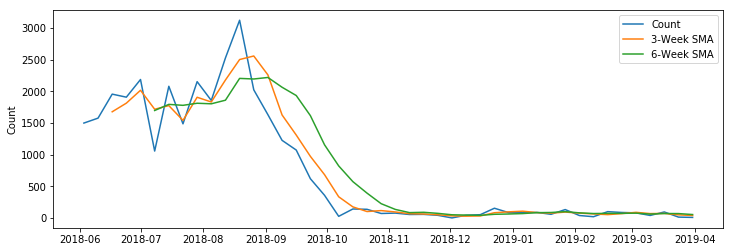

In [76]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df_ts_size.index, 
        df_ts_size,
        label='Count')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '3-Week SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '6-Week SMA')

ax.legend(loc='best')
ax.set_ylabel('Count')

## It looks like there were a lot of visits to the curriculum right when capstone projects were started.

In [77]:
ema_short = df_ts_size.ewm(span=3, adjust=False).mean()
ema_short[0:3]

2018-06-03    1498.0
2018-06-10    1537.0
2018-06-17    1746.0
Freq: W-SUN, Name: date, dtype: float64

In [78]:
ema_long = df_ts_size.ewm(span=6, adjust=False).mean()
ema_long[0:3]

2018-06-03    1498.000000
2018-06-10    1520.285714
2018-06-17    1644.489796
Freq: W-SUN, Name: date, dtype: float64

In [79]:
span = 6
ema_long = df_ts_size.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-6:-1].std()*3
lb = midband - ema_long[-6:-1].std()*3

Text(0, 0.5, 'Count')

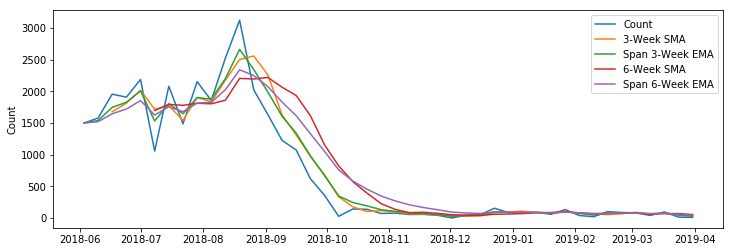

In [80]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df_ts_size.index, 
        df_ts_size,
        label='Count')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '3-Week SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 3-Week EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '6-Week SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 6-Week EMA')

ax.legend(loc='best')
ax.set_ylabel('Count')

# yhat = pd.DataFrame(dict(actual=test))

In [81]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')
df_user_count = cohort_24['user'].resample('M').mean()
idx = pd.date_range(
    df_user_count.sort_index().index.min(),
    df_user_count.sort_index().index.max(),
    freq='M'
)
df_user_count = df_user_count.reindex(idx, fill_value=0).fillna(value=0)

In [82]:
short_rolling = df_user_count.rolling(window=2).mean()
long_rolling = df_user_count.rolling(window=4).mean()

Text(0, 0.5, 'Count')

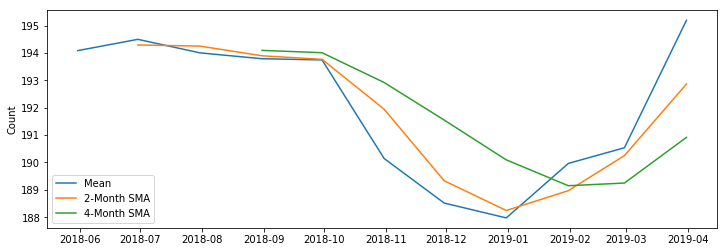

In [83]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df_user_count.index, 
        df_user_count,
        label='Mean')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '2-Month SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '4-Month SMA')

ax.legend(loc='best')
ax.set_ylabel('Count')

In [84]:
cohort_24.head()

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out,day_of_week
timestamp,,,,,,,,,,,,
2018-05-29 14:42:38,2018-05-29,2019-05-02 14:42:38,/,182,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday
2018-05-29 14:42:39,2018-05-29,2019-05-02 14:42:39,/,183,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,184,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,185,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday
2018-05-29 14:42:42,2018-05-29,2019-05-02 14:42:42,/,186,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday


In [85]:
cohort_24['user_id'] = cohort_24['user']

In [86]:
df_agg = cohort_24.groupby(['date','user'])['user_id'].count().reset_index().rename(index=str, columns={'user_id':'num_view'})

In [87]:
df_agg[df_agg.user == 182].head(10)

,date,user,num_view
0,2018-05-29,182,10
26,2018-05-30,182,5
53,2018-05-31,182,11
80,2018-06-01,182,10
123,2018-06-04,182,14
150,2018-06-05,182,1
177,2018-06-06,182,4
204,2018-06-07,182,4
272,2018-06-11,182,15
298,2018-06-12,182,8


In [88]:
cohort_24[cohort_24.user == 182]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date,running_days,days_out,day_of_week,user_id
timestamp,,,,,,,,,,,,,
2018-05-29 14:42:38,2018-05-29,2019-05-02 14:42:38,/,182,24,97.105.19.61,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday,182
2018-05-29 21:19:51,2018-05-29,2019-05-02 21:19:51,prework/cli,182,24,67.11.172.66,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday,182
2018-05-29 21:19:56,2018-05-29,2019-05-02 21:19:56,prework/cli/01-intro,182,24,67.11.172.66,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday,182
2018-05-29 21:20:51,2018-05-29,2019-05-02 21:20:51,prework/cli/02-listing-files,182,24,67.11.172.66,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday,182
2018-05-29 21:22:15,2018-05-29,2019-05-02 21:22:15,prework/cli/03-file-paths,182,24,67.11.172.66,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday,182
2018-05-29 21:23:38,2018-05-29,2019-05-02 21:23:38,prework/cli/04-navigating-the-filesystem,182,24,67.11.172.66,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday,182
2018-05-29 21:23:49,2018-05-29,2019-05-02 21:23:49,prework/cli/05-creating-files-and-directories,182,24,67.11.172.66,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday,182
2018-05-29 21:24:57,2018-05-29,2019-05-02 21:24:57,prework/cli/06-moving-files,182,24,67.11.172.66,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday,182
2018-05-29 21:25:16,2018-05-29,2019-05-02 21:25:16,appendix/further-reading/javascript/hoisting,182,24,67.11.172.66,Voyageurs,2018-05-29,2018-10-11,0,-135,Tuesday,182


In [89]:
df_agg = df_agg.set_index('date').rename(index=str, columns={'num_view':'ema'})
df_agg.head()

,user,ema
date,,
2018-05-29 00:00:00,182,10
2018-05-29 00:00:00,183,1
2018-05-29 00:00:00,184,2
2018-05-29 00:00:00,185,5
2018-05-29 00:00:00,186,2


In [90]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev*3
    ema['lb'] = ema.ema - ema.stdev*3
    return ema.reset_index()

In [91]:
# bands = []
# for user in users:
#     bb = bollinger_bands(df.user)
#     bands.append(bb)
    
# df2 = pd.concat(bands)

In [92]:
instructors = df[df.cohort_id == 28]
instructors.user.value_counts()

11     1525
1      1022
64     1001
314     704
248     600
211     563
53      321
312     131
146     102
397      74
40       66
370      54
Name: user, dtype: int64

In [93]:
int_id = list(instructors.user.unique())
int_id = sorted(int_id)
int_id

[1, 11, 40, 53, 64, 146, 211, 248, 312, 314, 370, 397]

In [94]:
instructors.head(20)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-12-06 14:15:29,2018-12-06,2019-05-02 14:15:29,appendix/further-reading/java/intellij-tomcat-...,53,28,97.105.19.58,Staff,2014-02-04,2014-02-04
2018-12-06 14:25:40,2018-12-06,2019-05-02 14:25:40,javascript-i,314,28,97.105.19.58,Staff,2014-02-04,2014-02-04
2018-12-06 14:25:41,2018-12-06,2019-05-02 14:25:41,javascript-i/coffee-project,314,28,97.105.19.58,Staff,2014-02-04,2014-02-04
2018-12-06 15:31:29,2018-12-06,2019-05-02 15:31:29,spring,40,28,170.248.173.247,Staff,2014-02-04,2014-02-04
2018-12-06 15:31:33,2018-12-06,2019-05-02 15:31:33,spring/fundamentals/security,40,28,170.248.173.247,Staff,2014-02-04,2014-02-04
2018-12-06 15:33:32,2018-12-06,2019-05-02 15:33:32,appendix/further-reading/spring/authorization,40,28,170.248.173.247,Staff,2014-02-04,2014-02-04
2018-12-06 15:34:29,2018-12-06,2019-05-02 15:34:29,spring/fundamentals/security/authentication,40,28,170.248.173.247,Staff,2014-02-04,2014-02-04
2018-12-06 15:38:58,2018-12-06,2019-05-02 15:38:58,appendix/further-reading/spring/authorization,40,28,170.248.173.247,Staff,2014-02-04,2014-02-04
2018-12-06 15:39:55,2018-12-06,2019-05-02 15:39:55,appendix/further-reading/spring/security-use-c...,40,28,170.248.173.247,Staff,2014-02-04,2014-02-04


In [95]:
instructors[instructors.path == '6.6.1_Logistic_Regression']

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2019-03-27 08:44:33,2019-03-27,2019-05-02 08:44:33,6.6.1_Logistic_Regression,248,28,97.105.19.58,Staff,2014-02-04,2014-02-04
2019-03-29 13:21:41,2019-03-29,2019-05-02 13:21:41,6.6.1_Logistic_Regression,397,28,108.84.76.42,Staff,2014-02-04,2014-02-04
2019-03-31 19:42:41,2019-03-31,2019-05-02 19:42:41,6.6.1_Logistic_Regression,1,28,70.121.210.246,Staff,2014-02-04,2014-02-04
2019-04-01 07:44:55,2019-04-01,2019-05-02 07:44:55,6.6.1_Logistic_Regression,1,28,97.105.19.58,Staff,2014-02-04,2014-02-04
2019-04-01 11:22:37,2019-04-01,2019-05-02 11:22:37,6.6.1_Logistic_Regression,248,28,97.105.19.58,Staff,2014-02-04,2014-02-04


In [96]:
df.cohort_id.value_counts()

24    34485
22    28268
23    26655
25    24681
26    24088
29    20471
27    19255
30     9060
1      8821
14     6523
21     6465
28     6163
31     2997
13     2163
17     1805
8      1671
18     1482
19      901
16      740
15      632
7       338
12      230
2        89
11       79
6        59
9         5
4         4
Name: cohort_id, dtype: int64

In [97]:
# ada_class = df[(df.path == '6.6.1_Logistic_Regression') & (df.cohort == '')]
# ada = list(ada_class.user.unique())
# ada = sorted(ada)
# ada

In [98]:
# ada_class.sample(20)

In [99]:
# df[df.cohort == '']

In [100]:
# Zach
df[df.user == 1]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,2019-05-02 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:02,2018-01-26,2019-05-02 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:05,2018-01-26,2019-05-02 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:06,2018-01-26,2019-05-02 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 10:40:15,2018-01-26,2019-05-02 10:40:15,javascript-i/functions,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 11:26:13,2018-01-26,2019-05-02 11:26:13,java-i,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 11:43:17,2018-01-26,2019-05-02 11:43:17,mkdocs/search_index.json,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-27 07:49:25,2018-01-27,2019-05-02 07:49:25,teams/13,1,8,72.177.226.58,Hampton,2015-09-22,2016-02-06
2018-01-29 11:41:51,2018-01-29,2019-05-02 11:41:51,javascript-i/conditionals,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06


In [101]:
# Dimitri..No
df[df.user == 146]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-03-19 08:35:51,2018-03-19,2019-05-02 08:35:51,/,146,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-03-19 08:37:27,2018-03-19,2019-05-02 08:37:27,content/html-css,146,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-03-19 08:37:27,2018-03-19,2019-05-02 08:37:27,content/html-css/gitbook/images/favicon.ico,146,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-03-19 08:37:30,2018-03-19,2019-05-02 08:37:30,content/html-css,146,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-03-19 08:37:35,2018-03-19,2019-05-02 08:37:35,content/html-css/introduction.html,146,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-03-19 08:38:04,2018-03-19,2019-05-02 08:38:04,content/html-css/elements.html,146,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-03-19 08:38:04,2018-03-19,2019-05-02 08:38:04,content/html-css/forms.html,146,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-03-19 08:38:05,2018-03-19,2019-05-02 08:38:05,content/html-css/css-i,146,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-03-19 08:38:05,2018-03-19,2019-05-02 08:38:05,content/html-css/css-i/gitbook/images/favicon.ico,146,1,97.105.19.61,Arches,2014-02-04,2014-04-22


In [102]:
# Maggie
df[df.user == 248]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-09-05 14:28:23,2018-09-05,2019-05-02 14:28:23,/,248,1,97.105.19.58,Arches,2014-02-04,2014-04-22
2018-09-07 14:53:23,2018-09-07,2019-05-02 14:53:23,/,248,1,97.105.19.58,Arches,2014-02-04,2014-04-22
2018-09-07 14:54:13,2018-09-07,2019-05-02 14:54:13,html-css,248,1,97.105.19.58,Arches,2014-02-04,2014-04-22
2018-09-07 14:56:07,2018-09-07,2019-05-02 14:56:07,html-css/introduction,248,1,97.105.19.58,Arches,2014-02-04,2014-04-22
2018-09-07 14:57:00,2018-09-07,2019-05-02 14:57:00,html-css/elements,248,1,97.105.19.58,Arches,2014-02-04,2014-04-22
2018-09-07 14:57:42,2018-09-07,2019-05-02 14:57:42,html-css/forms,248,1,97.105.19.58,Arches,2014-02-04,2014-04-22
2018-09-07 14:58:10,2018-09-07,2019-05-02 14:58:10,html-css/css-i,248,1,97.105.19.58,Arches,2014-02-04,2014-04-22
2018-09-07 14:58:16,2018-09-07,2019-05-02 14:58:16,html-css/css-i/introduction,248,1,97.105.19.58,Arches,2014-02-04,2014-04-22
2018-09-07 14:58:19,2018-09-07,2019-05-02 14:58:19,html-css/css-i/selectors-and-properties,248,1,97.105.19.58,Arches,2014-02-04,2014-04-22


In [103]:
# Mark
df[df.user == 397]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2019-03-29 13:02:00,2019-03-29,2019-05-02 13:02:00,/,397,28,108.84.76.42,Staff,2014-02-04,2014-02-04
2019-03-29 13:02:08,2019-03-29,2019-05-02 13:02:08,1._Fundamentals,397,28,108.84.76.42,Staff,2014-02-04,2014-02-04
2019-03-29 13:02:47,2019-03-29,2019-05-02 13:02:47,Pipeline_Demo,397,28,108.84.76.42,Staff,2014-02-04,2014-02-04
2019-03-29 13:03:57,2019-03-29,2019-05-02 13:03:57,1._Fundamentals,397,28,108.84.76.42,Staff,2014-02-04,2014-02-04
2019-03-29 13:04:16,2019-03-29,2019-05-02 13:04:16,4.0_overview,397,28,108.84.76.42,Staff,2014-02-04,2014-02-04
2019-03-29 13:04:38,2019-03-29,2019-05-02 13:04:38,4.1_introduction,397,28,108.84.76.42,Staff,2014-02-04,2014-02-04
2019-03-29 13:10:58,2019-03-29,2019-05-02 13:10:58,4.2_data_types_and_variables,397,28,108.84.76.42,Staff,2014-02-04,2014-02-04
2019-03-29 13:14:23,2019-03-29,2019-05-02 13:14:23,6.1_Overview,397,28,108.84.76.42,Staff,2014-02-04,2014-02-04
2019-03-29 13:15:11,2019-03-29,2019-05-02 13:15:11,6.2_About,397,28,108.84.76.42,Staff,2014-02-04,2014-02-04


In [104]:
df[df.user == 349]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2019-02-04 16:22:20,2019-02-04,2019-05-02 16:22:20,/,349,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-04 16:56:21,2019-02-04,2019-05-02 16:56:21,/,349,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-05 00:14:44,2019-02-05,2019-05-02 00:14:44,/,349,30,24.160.139.8,Ada,2019-02-04,2019-06-16
2019-02-05 00:14:47,2019-02-05,2019-05-02 00:14:47,1._Fundamentals,349,30,24.160.139.8,Ada,2019-02-04,2019-06-16
2019-02-05 09:00:11,2019-02-05,2019-05-02 09:00:11,/,349,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-05 09:00:24,2019-02-05,2019-05-02 09:00:24,1._Fundamentals,349,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-05 09:02:01,2019-02-05,2019-05-02 09:02:01,1._Fundamentals,349,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-06 08:38:33,2019-02-06,2019-05-02 08:38:33,/,349,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-06 08:39:03,2019-02-06,2019-05-02 08:39:03,1._Fundamentals,349,30,97.105.19.58,Ada,2019-02-04,2019-06-16


In [105]:
df.head()

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,2019-05-02 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:02,2018-01-26,2019-05-02 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:05,2018-01-26,2019-05-02 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:06,2018-01-26,2019-05-02 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 10:40:15,2018-01-26,2019-05-02 10:40:15,javascript-i/functions,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06


In [106]:
df.tail()

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2019-04-02 11:09:00,2019-04-02,2019-05-02 11:09:00,javascript-i/javascript-with-html,384,31,97.105.19.58,Andromeda,2019-03-18,2019-07-30
2019-04-02 11:11:18,2019-04-02,2019-05-02 11:11:18,javascript-i/introduction/working-with-data-ty...,384,31,97.105.19.58,Andromeda,2019-03-18,2019-07-30
2019-04-02 11:11:23,2019-04-02,2019-05-02 11:11:23,javascript-i,373,31,97.105.19.58,Andromeda,2019-03-18,2019-07-30
2019-04-02 11:11:25,2019-04-02,2019-05-02 11:11:25,javascript-i/introduction/working-with-data-ty...,376,31,97.105.19.58,Andromeda,2019-03-18,2019-07-30
2019-04-02 11:11:29,2019-04-02,2019-05-02 11:11:29,javascript-i/introduction/working-with-data-ty...,373,31,97.105.19.58,Andromeda,2019-03-18,2019-07-30


In [107]:
df[((df.index < '2018-02-10') & (df.ip == '97.105.19.61')) & ((df.index > '2019-02-10') & (df.ip == '97.105.19.58'))]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,


In [108]:
old = pd.DataFrame(df.user[(df.index < '2018-02-10') & (df.ip == '97.105.19.61')].unique())
old.rename(index=str, columns={0:'user'}, inplace=True)
old.head()

,user
0,1
1,2
2,3
3,4
4,5


In [109]:
new = pd.DataFrame(df.user[(df.index > '2019-02-10') & (df.ip == '97.105.19.58')].unique())
new.rename(index=str, columns={0:'user'}, inplace=True)
new.head()

,user
0,41
1,53
2,314
3,223
4,315


In [110]:
old_and_new = old.merge(new, how='inner', on='user')
old_and_new

,user
0,1
1,41
2,11
3,64
4,53


### Above, we see users that have accessed curriculum from Codeup IP addresses both at the beginning of the log data and at the end, indicating that these users are most likely instructors/employees.  From there, we could find similiarities to find other instructors/employees.

In [111]:
df[df.user==1]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,2019-05-02 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:02,2018-01-26,2019-05-02 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:05,2018-01-26,2019-05-02 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:06,2018-01-26,2019-05-02 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 10:40:15,2018-01-26,2019-05-02 10:40:15,javascript-i/functions,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 11:26:13,2018-01-26,2019-05-02 11:26:13,java-i,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 11:43:17,2018-01-26,2019-05-02 11:43:17,mkdocs/search_index.json,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-27 07:49:25,2018-01-27,2019-05-02 07:49:25,teams/13,1,8,72.177.226.58,Hampton,2015-09-22,2016-02-06
2018-01-29 11:41:51,2018-01-29,2019-05-02 11:41:51,javascript-i/conditionals,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06


### User 1 has Cohort 8 to begin and then ends in Cohort 28.

In [112]:
df[df.user==11]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-01-26 10:14:47,2018-01-26,2019-05-02 10:14:47,/,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-01-26 10:14:51,2018-01-26,2019-05-02 10:14:51,javascript-i,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-01-26 10:15:02,2018-01-26,2019-05-02 10:15:02,javascript-i/functions,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-01-26 11:46:29,2018-01-26,2019-05-02 11:46:29,appendix/further-reading/javascript/hoisting.html,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-01-26 11:46:39,2018-01-26,2019-05-02 11:46:39,appendix,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-01-26 11:46:47,2018-01-26,2019-05-02 11:46:47,appendix/further-reading/javascript/hoisting,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-01-26 11:47:01,2018-01-26,2019-05-02 11:47:01,appendix/capstone-workbook,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-01-26 11:47:03,2018-01-26,2019-05-02 11:47:03,javascript-i,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22
2018-01-26 11:47:05,2018-01-26,2019-05-02 11:47:05,javascript-i/functions,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22


### User 11 starts in Cohort 1 and ends in Cohort 28.

In [257]:
web1 = pd.DataFrame(df.user[df.path == 'java-i'].unique())
web1.rename(index=str, columns={0:'user'}, inplace=True)
web1.shape

(244, 1)

In [113]:
web = pd.DataFrame(df.user[df.path == 'content/html-css'].unique())
web.rename(index=str, columns={0:'user'}, inplace=True)
web.shape

(63, 1)

In [114]:
web.head()

,user
0,19
1,155
2,29
3,138
4,6


In [115]:
datas = pd.DataFrame(df.user[(df.path == 'Pipeline_Demo') | (df.path == 'Regression_Python')].unique())
datas.rename(index=str, columns={0:'user'}, inplace=True)
datas.shape

(27, 1)

### The list below are users that have accessed both 'content/html-css', which can be considered a page for WebDev, and 'Pipeline_Demo', which can be considered a page for the DS curriculum.

In [258]:
both = web1.merge(datas, how='inner', on='user')
list(sorted(both.user))

[1, 11, 18, 146, 186, 201, 223, 282]

In [116]:
both = web.merge(datas, how='inner', on='user')
list(sorted(both.user))

[11, 18, 146, 186, 201]

### Let's try figuring out which pages are in both WD and DS.  We'll try and isolate a user that seems to only have accessed DS pages and a user that seems to only have accessed WD pages and then inner join their unique pages.

In [117]:
df.head(3)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,2019-05-02 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:02,2018-01-26,2019-05-02 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:05,2018-01-26,2019-05-02 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06


In [118]:
df[df.user == 361]

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2019-02-04 16:56:59,2019-02-04,2019-05-02 16:56:59,/,361,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-04 21:48:02,2019-02-04,2019-05-02 21:48:02,/,361,30,99.61.28.109,Ada,2019-02-04,2019-06-16
2019-02-05 08:50:46,2019-02-05,2019-05-02 08:50:46,/,361,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-05 08:50:57,2019-02-05,2019-05-02 08:50:57,1._Fundamentals,361,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-06 09:05:13,2019-02-06,2019-05-02 09:05:13,/,361,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-06 09:05:24,2019-02-06,2019-05-02 09:05:24,1._Fundamentals,361,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-06 09:05:45,2019-02-06,2019-05-02 09:05:45,1.10_JobReq_Indeed,361,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-07 13:54:58,2019-02-07,2019-05-02 13:54:58,/,361,30,97.105.19.58,Ada,2019-02-04,2019-06-16
2019-02-07 13:55:18,2019-02-07,2019-05-02 13:55:18,1._Fundamentals,361,30,97.105.19.58,Ada,2019-02-04,2019-06-16


In [119]:
ds_curr = pd.DataFrame(df.path[df.cohort_id == 30].unique())
ds_curr.rename(index=str, columns={0:'path'}, inplace=True)
ds_curr.shape

(194, 1)

In [122]:
list(ds_curr.path)

['/',
 '3.0-mysql-overview',
 'search/search_index.json',
 '2.00.02_Navigating_Excel',
 '1._Fundamentals',
 '2.00.00_Excel_Prob_Stats',
 '1.10_JobReq_Indeed',
 '5._Regression',
 '2.00.01_Intro_Excel',
 '3.1-mysql-introduction',
 '2.00.03_Import_Excel',
 '2.00.04_PrepareData_Excel',
 'mac-tips',
 'Pipeline_Demo',
 'git',
 '4.0_overview',
 '3.3-tables',
 'Excel_Shortcuts',
 '2.01.00_Descriptive_Stats',
 '4.6.0_DS_Libraries_Overview',
 '2.00.05_Charts_PivotTables_Sparklines',
 '2.02.04_Distribution_and_Test',
 '5.02_Prep',
 '5.01_Acquire',
 '2.02.00_Inferential_Stats',
 '2.02.01_Probability',
 '2.02.02_Sampling',
 '2.02.03_Power_Analysis',
 '2.02.05_Compare_Means',
 '2.02.06_Correlation',
 'DataSets_PneumoniaDetection',
 'database-design',
 '3.2-databases',
 '3.4-basic-statements',
 '3.6-functions',
 '2.03.06_CorrelationTests',
 '2.02.01_Distributions',
 '2.03.02_Sampling',
 '6.01.03_Summarize',
 'Model_NaiveBayes',
 '6._Classification',
 '3.5.0-clauses-overview',
 '3.5.1-where',
 '3.5.2-

In [123]:
ds_curr['path'] = ds_curr['path'].str.split('_', 1).str[1]

ds_curr.head()

,path
0,NaN
1,NaN
2,index.json
3,Navigating_Excel
4,Fundamentals


In [124]:
list(ds_curr.path.unique())

[nan,
 'index.json',
 'Navigating_Excel',
 'Fundamentals',
 'Excel_Prob_Stats',
 'JobReq_Indeed',
 'Regression',
 'Intro_Excel',
 'Import_Excel',
 'PrepareData_Excel',
 'Demo',
 'overview',
 'Shortcuts',
 'Descriptive_Stats',
 'DS_Libraries_Overview',
 'Charts_PivotTables_Sparklines',
 'Distribution_and_Test',
 'Prep',
 'Acquire',
 'Inferential_Stats',
 'Probability',
 'Sampling',
 'Power_Analysis',
 'Compare_Means',
 'Correlation',
 'PneumoniaDetection',
 'CorrelationTests',
 'Distributions',
 'Summarize',
 'NaiveBayes',
 'Classification',
 'SocialNetworkAnalysis',
 'Recommenders',
 'NLP',
 'Intro.md',
 'Acquire_WebScraping',
 'introduction',
 'data_types_and_variables',
 'control_structures',
 'functions',
 'introduction_to_pandas',
 'EntityLabeling',
 'FeatureExtraction_FreqBased',
 'FeatureExtraction_Word2Vec',
 'listing_files',
 'index',
 'intro',
 'file_paths',
 'navigating_the_filesystem',
 'creating_files_and_directories',
 'moving_files',
 'more_topics',
 'MLModeling',
 'Param

In [125]:
ds_curr['path'] = ds_curr['path'].str.replace('_', '/')
ds_curr.head()

,path
0,NaN
1,NaN
2,index.json
3,Navigating/Excel
4,Fundamentals


In [126]:
web_curr = pd.DataFrame(df.path[df.user == 341].unique())
web_curr.rename(index=str, columns={0:'path'}, inplace=True)
web_curr.shape

(186, 1)

In [128]:
list(web_curr.path.unique())

['/',
 'toc',
 'html-css',
 'html-css/introduction',
 'html-css/elements',
 'html-css/forms',
 'html-css/css-i',
 'html-css/css-i/positioning',
 'html-css/css-i/introduction',
 'html-css/css-i/selectors-and-properties',
 'search/search_index.json',
 'html-css/css-i/box-model',
 'examples/css/css_selectors.html',
 'examples/css/messages.html',
 'examples/css/login-form.html',
 'examples/css/twitter.html',
 'html-css/css-ii',
 'html-css/css-ii/media-queries',
 'html-css/css-ii/grids',
 'html-css/css-ii/bootstrap-introduction',
 'examples/css/media-queries.html',
 'html-css/css-ii/bootstrap-grid-system',
 'examples/bootstrap-grid/assets.zip',
 'javascript-i',
 'javascript-i/introduction',
 'javascript-i/introduction/primitive-types',
 'javascript-i/introduction/operators',
 'javascript-i/introduction/variables',
 'javascript-i/introduction/working-with-data-types-operators-and-variables',
 'javascript-i/javascript-with-html',
 'javascript-i/functions',
 'appendix',
 'appendix/git/branchin

In [129]:
both_curr = web_curr.merge(ds_curr, how='inner', on='path')
list(sorted(both_curr.path))

[]

### We are not able to find pages that are in both WD and DS.

In [157]:
df.head(3)

,date,time,path,user,cohort_id,ip,cohort,start_date,end_date
timestamp,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,2019-05-02 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:02,2018-01-26,2019-05-02 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2018-01-26 09:56:05,2018-01-26,2019-05-02 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06


# Clustering - DBSCAN

In [130]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [131]:
store = pd.read_csv("customers.csv")

store.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [132]:
store.tail()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


In [133]:
store.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [134]:
store[(store.Channel == 1) & (store.Region == 1)]['Fresh'].nunique()

59

In [135]:
store[(store.Channel == 1) & (store.Region == 1)].count()

Channel             59
Region              59
Fresh               59
Milk                59
Grocery             59
Frozen              59
Detergents_Paper    59
Delicassen          59
dtype: int64

In [136]:
store[(store.Channel == 2) & (store.Region == 1)]['Fresh'].nunique()

18

In [137]:
store = store[["Grocery", "Frozen", "Fresh"]]

In [138]:
np_array = store.values.astype("float32", copy = False)
np_array[0:10]

array([[ 7561.,   214., 12669.],
       [ 9568.,  1762.,  7057.],
       [ 7684.,  2405.,  6353.],
       [ 4221.,  6404., 13265.],
       [ 7198.,  3915., 22615.],
       [ 5126.,   666.,  9413.],
       [ 6975.,   480., 12126.],
       [ 9426.,  1669.,  7579.],
       [ 6192.,   425.,  5963.],
       [18881.,  1159.,  6006.]], dtype=float32)

In [139]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[-0.0411149 , -0.5893672 ,  0.05293319],
       [ 0.17031837, -0.27013618, -0.39130196],
       [-0.0281571 , -0.13753572, -0.44702926],
       [-0.3929769 ,  0.68714434,  0.1001114 ],
       [-0.07935619,  0.17385884,  0.8402394 ],
       [-0.29763708, -0.49615505, -0.20480551],
       [-0.10284877, -0.5345123 ,  0.00995035],
       [ 0.15535896, -0.28931478, -0.34998146],
       [-0.18533617, -0.54585445, -0.4779009 ],
       [ 1.1514235 , -0.3944878 , -0.4744971 ]], dtype=float32)

In [140]:
dbsc = DBSCAN(eps = .75, min_samples = 10).fit(np_array)

In [141]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [142]:
store['labels'] = labels
store.labels.value_counts()

 0    405
-1     35
Name: labels, dtype: int64

In [143]:
store[store.labels==-1].head()

,Grocery,Frozen,Fresh,labels
23,22019,5154,26373,-1
39,902,10002,56159,-1
47,55571,7782,44466,-1
61,59598,3254,35942,-1
65,45828,36,85,-1


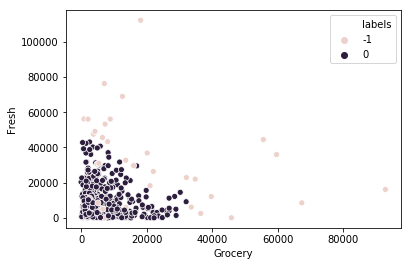

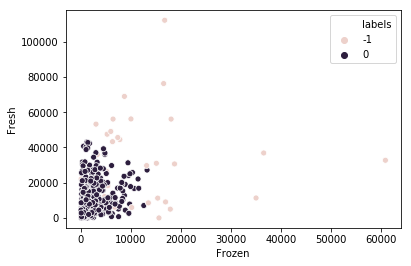

In [144]:
sns.scatterplot(store.Grocery, store.Fresh, hue=store.labels)
plt.show()

sns.scatterplot(store.Frozen, store.Fresh, hue=store.labels)
plt.show()

Text(0.5, 0, 'Grocery')

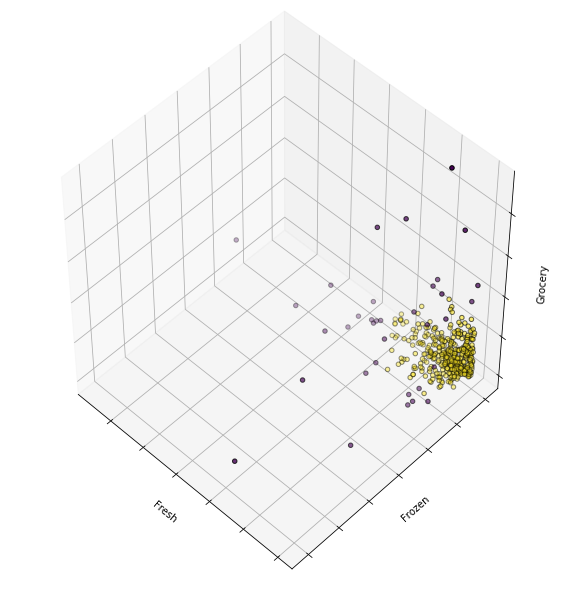

In [145]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(store.Fresh, store.Frozen, store.Grocery,
           c=store.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Grocery')

In [146]:
zillow = pd.read_csv('zillow_properties.csv')

In [147]:
zillow.shape

(167854, 68)

In [148]:
zillow = reindex_zillow(zillow)
drop_land_listings(zillow)
zillow.shape

(112689, 67)

In [149]:
convert_num_to_categorical(zillow)
convert_numerical_object_to_int(zillow)

,parcelid,logerror,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,transactiondate,yearbuilt,fips,latitude,longitude,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,3.0,2.0,1684.0,20160101,1959.0,6037.0,34280990.0,-118488536.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.168400,4.0,3.5,2263.0,20160101,2014.0,6059.0,33668120.0,-117677556.0,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.004000,2.0,3.0,2217.0,20160101,1940.0,6037.0,34136312.0,-118175032.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
4,14432541,-0.005000,4.0,2.5,2283.0,20160102,1981.0,6059.0,33485643.0,-117700234.0,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
5,11509835,-0.270500,4.0,4.0,3067.0,20160102,1982.0,6037.0,33870089.0,-118402768.0,...,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.57,NaN,NaN,6.037621e+13
6,12286022,0.044000,2.0,1.0,1297.0,20160102,1939.0,6037.0,33899475.0,-118212720.0,...,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.97,NaN,NaN,6.037542e+13
10,10854446,0.382500,2.0,2.0,1417.0,20160103,1954.0,6037.0,34164671.0,-118477995.0,...,NaN,NaN,55396.0,105954.0,2015.0,50558.0,1443.69,NaN,NaN,6.037141e+13
11,11672170,-0.016100,5.0,4.0,3080.0,20160103,1995.0,6037.0,34072220.0,-118547322.0,...,NaN,NaN,559040.0,1090127.0,2015.0,531087.0,13428.94,NaN,NaN,6.037263e+13
12,10949761,0.034400,3.0,2.0,1484.0,20160103,1944.0,6037.0,34189804.0,-118339183.0,...,NaN,NaN,29551.0,70119.0,2015.0,40568.0,832.35,NaN,NaN,6.037311e+13
14,14148540,-0.045000,2.0,2.0,1367.0,20160103,1955.0,6059.0,33913333.0,-117914140.0,...,1.0,NaN,78565.0,254817.0,2015.0,176252.0,3192.28,NaN,NaN,6.059002e+13


In [150]:
zillow.drop(columns=['airconditioningtypeid',
 'airconditioningdesc',
 'architecturalstyletypeid',
 'architecturalstyledesc',
 'basementsqft',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'buildingclassdesc',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'heatingorsystemdesc',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidneighborhood',
 'storytypeid',
 'storydesc',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'typeconstructiondesc',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'censustractandblock'], axis=1, inplace=True)

In [151]:
zillow['yearbuilt'].fillna(1960, inplace=True)

In [152]:
zillow.dropna(axis=0, inplace=True)
zillow.isnull().sum()

parcelid                        0
logerror                        0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
transactiondate                 0
yearbuilt                       0
fips                            0
latitude                        0
longitude                       0
calculatedbathnbr               0
fullbathcnt                     0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
propertylandusedesc             0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
dtype: int64

In [153]:
zillow.drop(zillow.loc[zillow['regionidzip'] > 100000].index, inplace=True)
zillow.drop(zillow.loc[zillow['calculatedfinishedsquarefeet'] < 450].index, inplace=True)

In [154]:
def maggie_remove_outliers(df):
    keys = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet',
                          'structuretaxvaluedollarcnt','landtaxvaluedollarcnt']
    values = [(1,7), (1,7), (500,8000), (25000,2000000), (10000,2500000)]

    dictionary = dict(zip(keys, values))

    for key, value in dictionary.items():
        df = df[df[key] >= value[0]]
        df = df[df[key] <= value[1]]
    return df

In [155]:
zillow = maggie_remove_outliers(zillow)
zillow.describe()

,parcelid,logerror,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,transactiondate,yearbuilt,latitude,longitude,calculatedbathnbr,fullbathcnt,lotsizesquarefeet,regionidzip,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
count,1.071490e+05,107149.000000,107149.000000,107149.000000,107149.000000,1.071490e+05,107149.000000,1.071490e+05,1.071490e+05,107149.000000,107149.000000,1.071490e+05,107149.000000,107149.000000,1.071490e+05,1.071490e+05,1.071490e+05,107149.000000
mean,1.299494e+07,0.014433,3.319116,2.302355,1904.860521,2.016521e+07,1963.957116,3.402149e+07,-1.181903e+08,2.302355,2.235289,1.104254e+04,96577.995856,1.965207,1.830208e+05,4.799604e+05,2.969395e+05,6076.510695
std,2.528371e+06,0.161052,0.892458,0.935330,877.060043,4.955056e+03,22.476401,2.759448e+05,3.599116e+05,0.935330,0.912038,8.468260e+04,419.362372,3.182551,1.742176e+05,4.355873e+05,3.098105e+05,5268.387500
min,1.071174e+07,-4.655420,1.000000,1.000000,500.000000,2.016010e+07,1880.000000,3.334004e+07,-1.194753e+08,1.000000,1.000000,2.360000e+02,95982.000000,0.000000,2.500000e+04,3.615200e+04,1.009300e+04,49.080000
25%,1.150601e+07,-0.025195,3.000000,2.000000,1296.000000,2.016061e+07,1951.000000,3.382265e+07,-1.184003e+08,2.000000,2.000000,5.615000e+03,96213.000000,0.000000,7.989900e+04,2.050790e+05,8.528100e+04,2931.880000
50%,1.263826e+07,0.006000,3.000000,2.000000,1674.000000,2.016101e+07,1961.000000,3.402204e+07,-1.181427e+08,2.000000,2.000000,6.857000e+03,96424.000000,0.000000,1.319950e+05,3.710330e+05,2.174020e+05,4780.900000
75%,1.414618e+07,0.038913,4.000000,3.000000,2291.000000,2.017052e+07,1979.000000,3.418978e+07,-1.179237e+08,3.000000,3.000000,8.763000e+03,96996.000000,5.000000,2.201690e+05,6.000000e+05,3.950000e+05,7331.740000
max,1.629608e+08,4.445000,7.000000,7.000000,7985.000000,2.017092e+07,2016.000000,3.481877e+07,-1.175546e+08,7.000000,7.000000,6.971010e+06,97344.000000,15.000000,1.976957e+06,4.403314e+06,2.498951e+06,173218.070000
